In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, r2_score, f1_score, mean_squared_error
import statsmodels.api as sm


data_dir = "wine+quality"

In [2]:
df_red = pd.read_csv(f"{data_dir}/winequality-red.csv", delimiter=";")
df_red.info()
df_red.describe() # можемо зменшити типи до int16 та float34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [3]:
# змінимо типи
# df_red[df_red.select_dtypes(include="float").columns] = df_red.select_dtypes(include="float").astype("float32")
df_red["quality"] = df_red["quality"].astype("int16")

Text(0, 0.5, 'count')

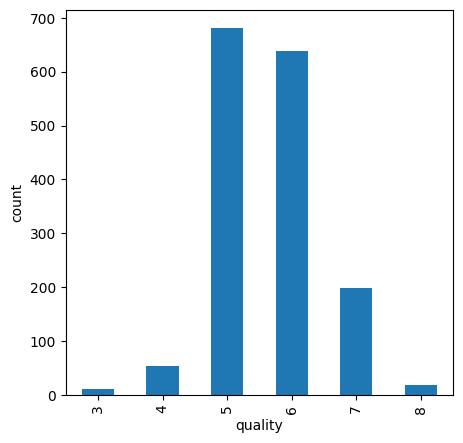

In [4]:
# подивимось розподіл таргетів (якість вин) у датасеті
df_red["quality"].describe()

plt.figure(figsize=(5, 5))
df_red["quality"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("quality")
plt.ylabel("count")

# бачимо, що таргети в датасеті розподілені дуже не рівномірно, тож в ідеалі нам би мати більше даних по вином з якістю 3, 4, 8, 7. 
# можна було б також отримати дані по винам з якістю 3, 4 та 8, і навчити модель на цих даних, зменшивши кількість даних по винам 5 та 6. 
# Це б спростило процес збору даних 

Створимо нові фічі

Text(0.5, 1.0, 'Кількість вин за типом')

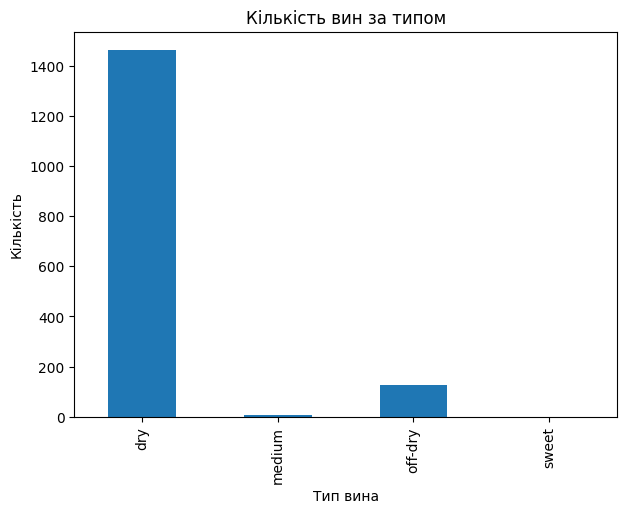

In [5]:
df_red["dry"] = (df_red["residual sugar"] < 4).astype("int8")
df_red["off-dry"] = ((df_red["residual sugar"] >= 4) & (df_red["residual sugar"] < 12)).astype("int8")
df_red["medium"] = ((df_red["residual sugar"] >= 12) & (df_red["residual sugar"] < 45) ).astype("int8")
df_red["sweet"] = (df_red["residual sugar"] >= 45).astype("int8")

# Створення нової таблиці для підрахунку значень
sugar_types = df_red[["dry", "off-dry", "medium", "sweet"]].sum()

# Побудова стовпчастої діаграми для різних категорій вина
plt.figure(figsize=(7, 5))
sugar_types.sort_index().plot(kind="bar")
plt.xlabel("Тип вина")
plt.ylabel("Кількість")
plt.title("Кількість вин за типом")

# бачимо, щоо значна більшість вин є сухими, що потенційно може ускладнити нам навчання моделі

In [6]:
# перевіримо на відсутні значення
df_red.isna().any() # бачимо що пропуски даних відсутні

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dry                     False
off-dry                 False
medium                  False
sweet                   False
dtype: bool

<Axes: >

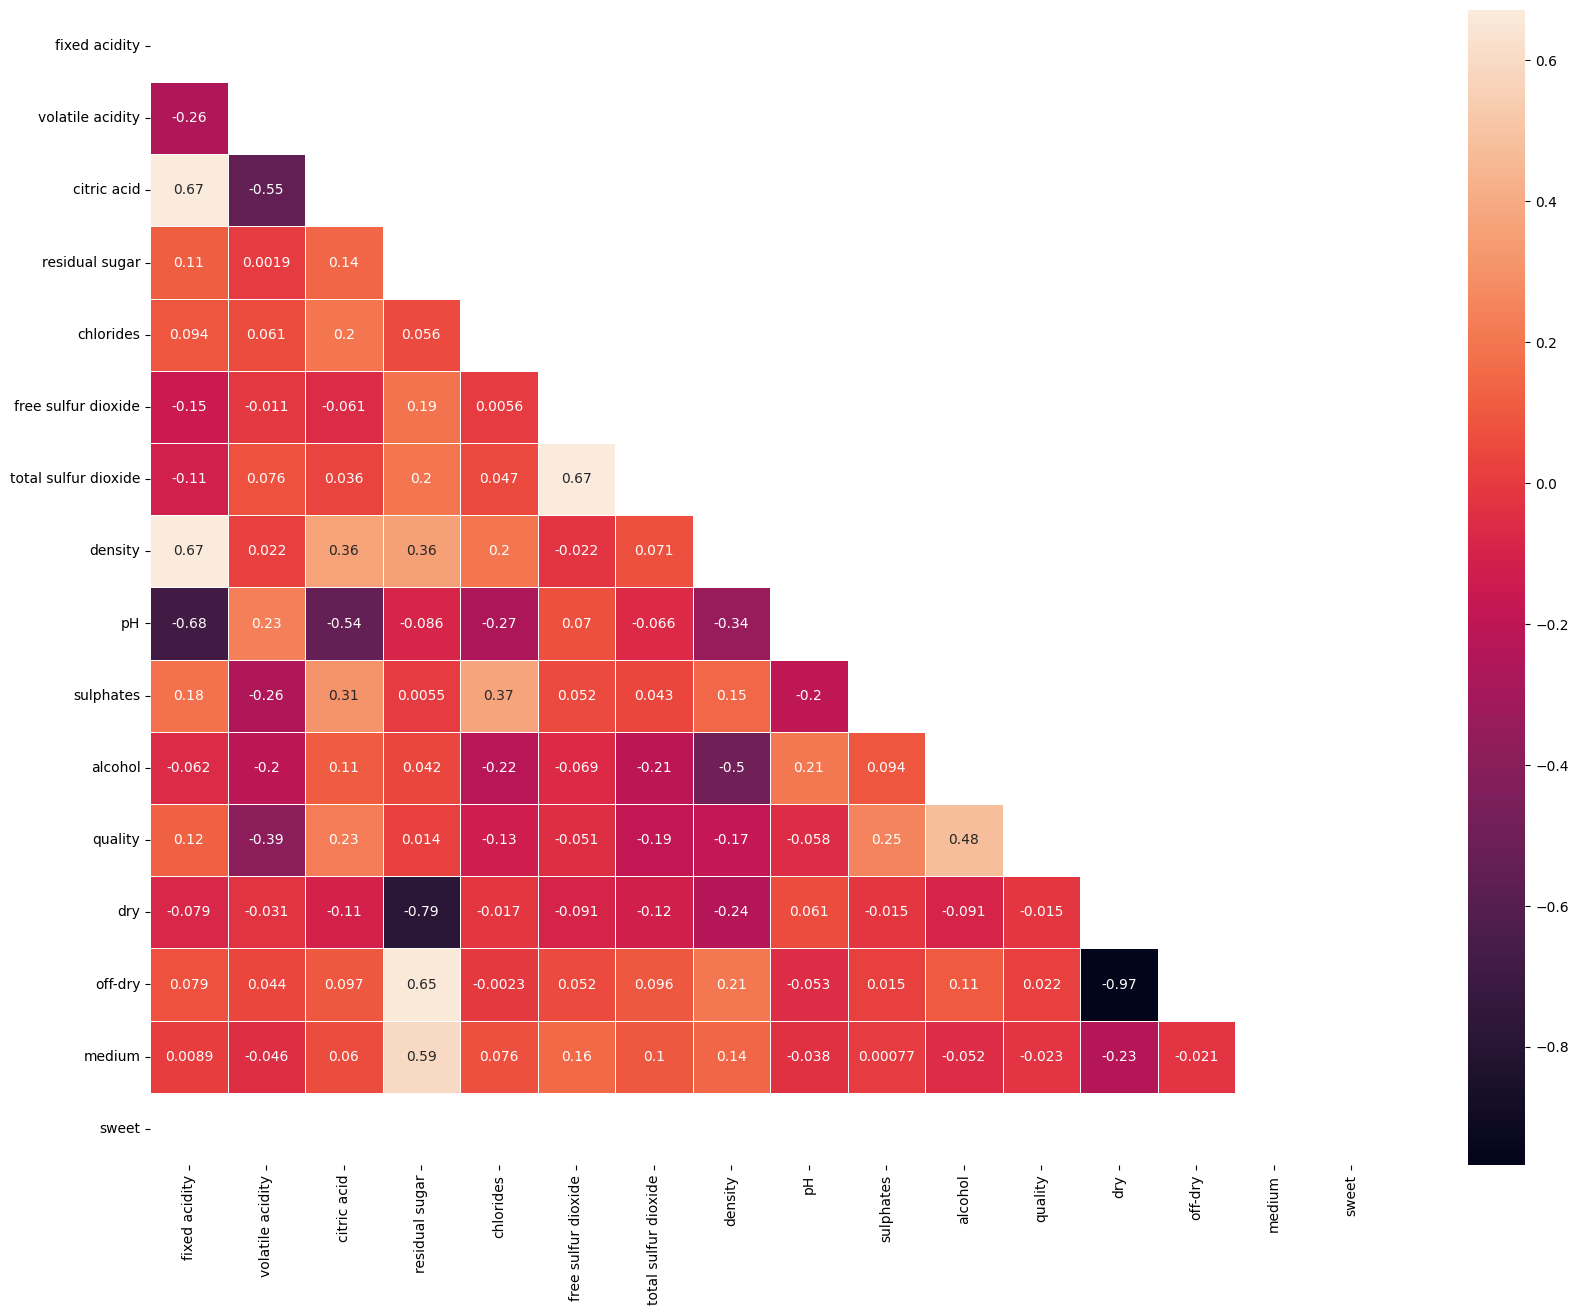

In [7]:
#категоріальних фіч у датафреймі теж немає
#подивимось кореляцію фіч
corr_matrix = df_red.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=0.5)
# бачимо, що фічі не мають занадто великої кореляції між собою, тож видаляти нічого не потрібно

In [8]:
def repr_df_by_tsne(df: pd.DataFrame, tsne_repr, show_labels=False, rows=3,figsize=(12, 5)):
    _, axes = plt.subplots(rows, round(len(df.columns) / rows), sharey=True, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        target = df[col]

        # Отримання унікальних значень та кольорів для кожного з них
        target_unique = np.sort(target.unique())
        colors = plt.cm.rainbow(np.linspace(0, 1, len(target_unique)))

        # Малювання кожного унікального значення окремо з власним кольором
        for val, color in zip(target_unique, colors):
            mask = target == val
            ax.scatter(tsne_repr[mask, 0], tsne_repr[mask, 1], alpha=0.5, label=val if show_labels else None, color=color)

        # Налаштування заголовків та легенди
        ax.set_title(f't-SNE за {col}')
        if show_labels:
            ax.legend(title=col)

    # Налаштування зовнішнього вигляду графіку
    plt.tight_layout()
    plt.show()


In [9]:
scaler = StandardScaler()
df_scalled = scaler.fit_transform(df_red)

tsne = TSNE(random_state=42)
tsne_repr = tsne.fit_transform(df_scalled)

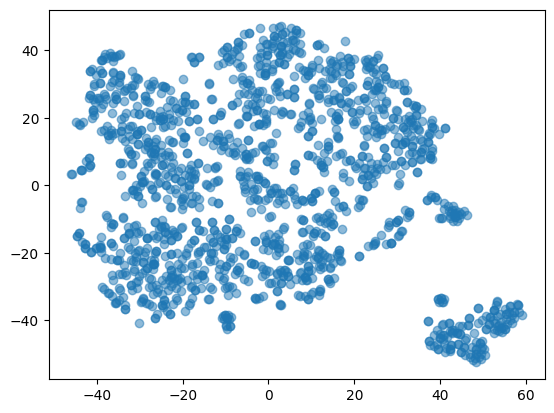

In [10]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], alpha=0.5)
# бачимо наявність деяких класів, один дуже ярко виражений та щє приблизно 4 менш виражених

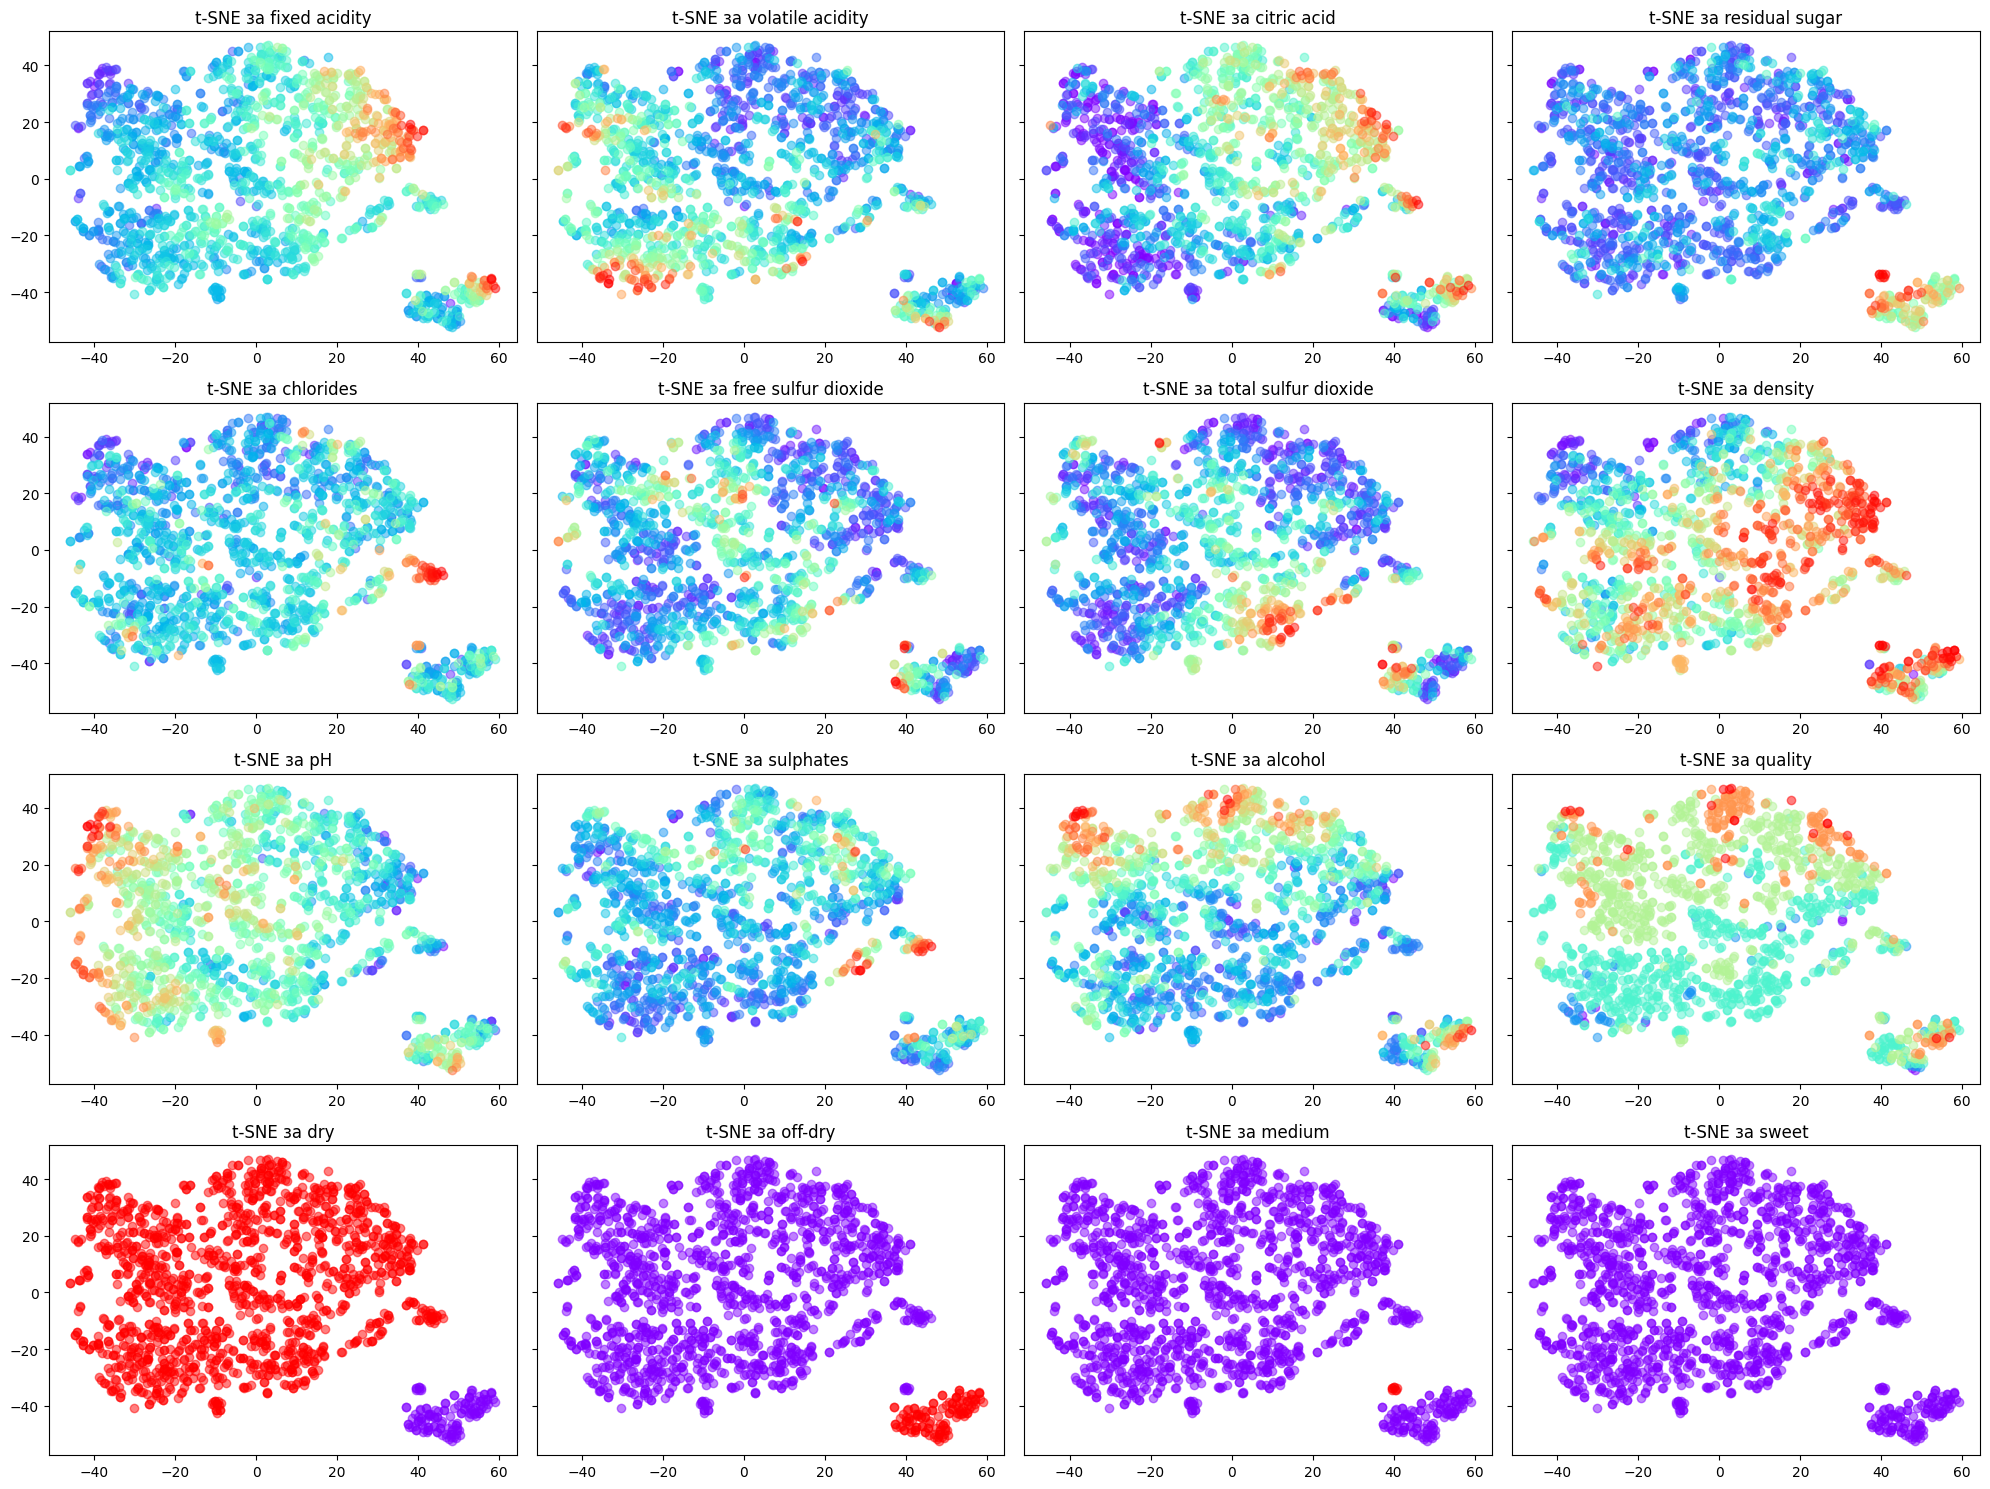

In [11]:
#Подивимось репрезентацію по фічам
repr_df_by_tsne(df=df_red, tsne_repr=tsne_repr, show_labels=False, rows=4, figsize=(20, 15))

#бачимо певні зв'язки, як от вина кращої якості мають більший показник alcohol, Ph має силььний вплив на якість, кращі вина - то сухі.
# UPD: верхнє твердження було написано до того, як я додав фічі з типами вин. 
# вцілому бачимо, що фічі мають різну ступінь впливу на якість вин, При цьому вони, глобально, мають зрозумілий, впорядкований розподіл на репрезентації

In [12]:
# ось і наші класи: за фактом це якраз наші фічі - розбиття по сухості.
# Є певні залежності якості від хімічного складу для різних типів вин. 
# враховуючи що сама по собі оцінка якості вина є суб'єктивною, а не математично обоснованою та те що якість для кожного типа вина має свої особливості
# додавши до цього тє що у нас великий дісбаланс по класам якості тай щє по видам вин за сухістю - можеммо не сподіватись на дуже хороші результати з наявними даними

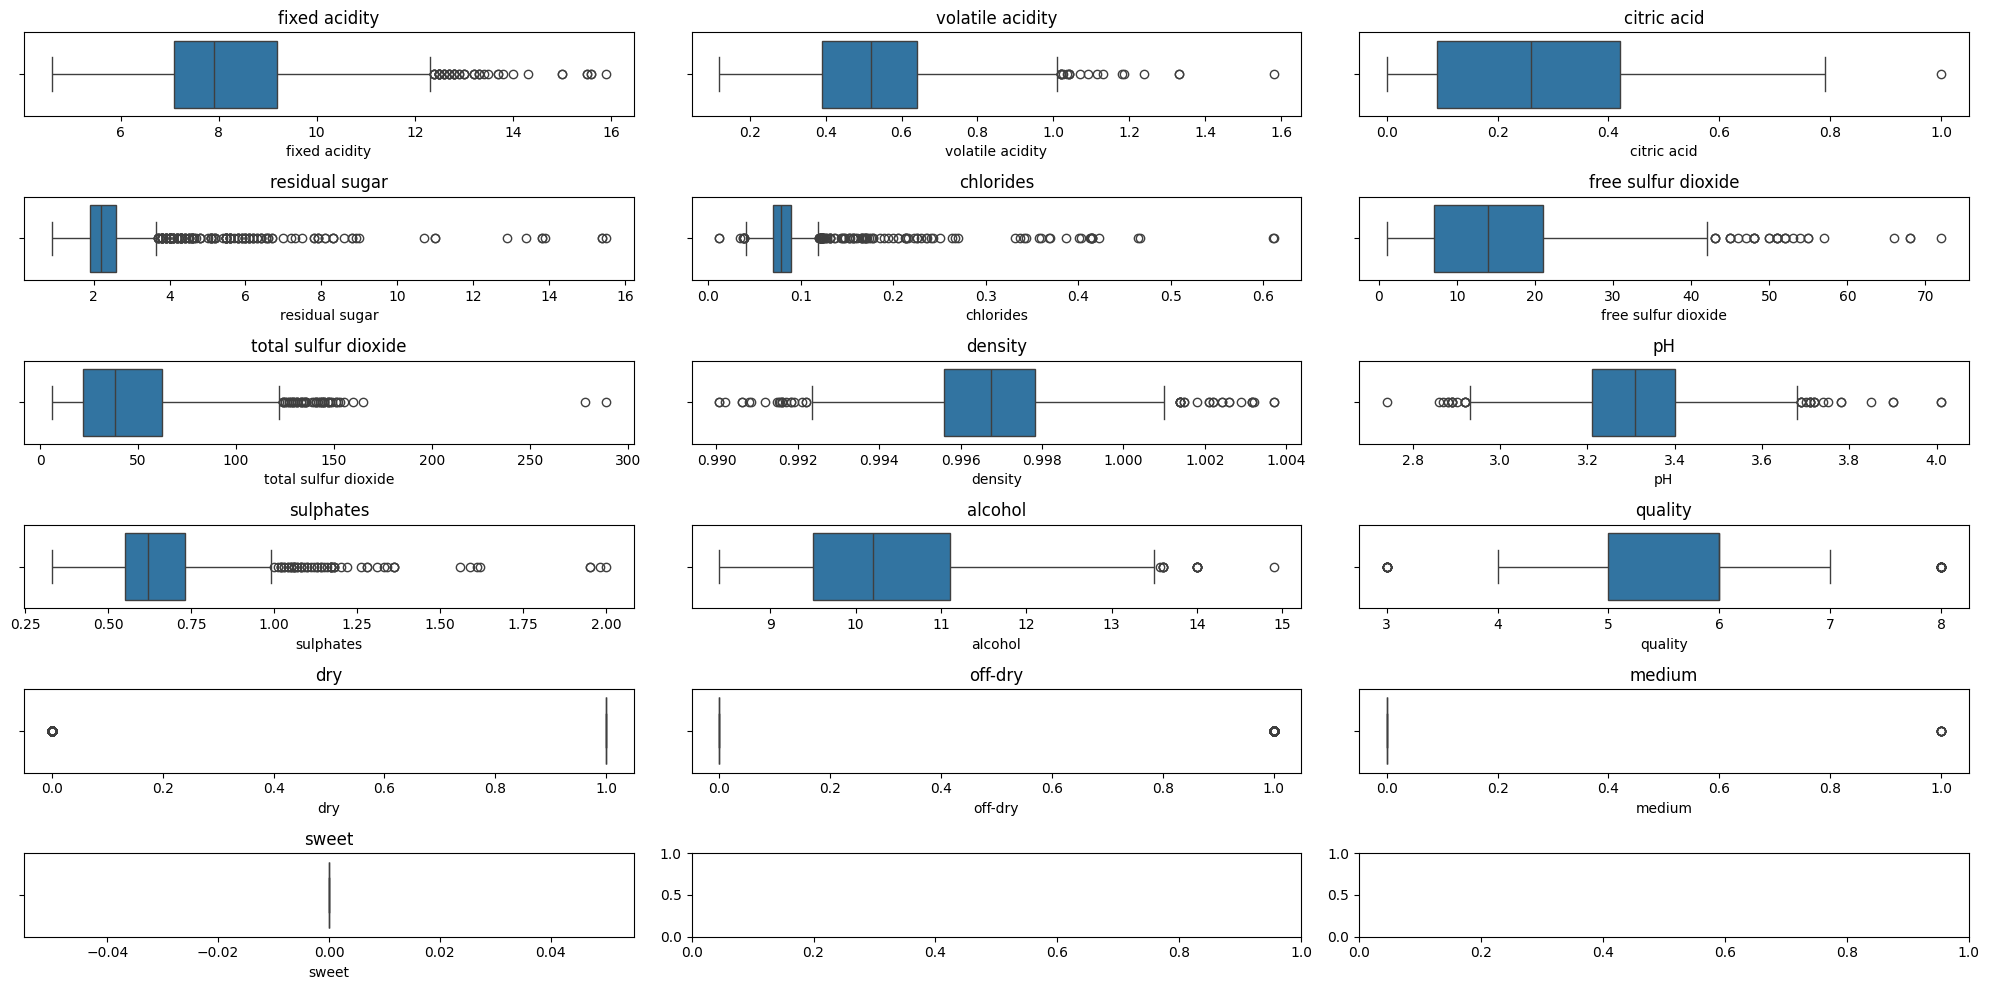

In [13]:
# подивимось на аномальні дані, які могли б заважати навчанню
# df.plot(
#     kind="box", subplots=True, layout=(3, 4), sharex=False, figsize=(20, 10)
# ) # можна було б не запарюватись з кодом нижче, але цей вивід візуально не дуже


# Визначаємо кількість підграфіків
vals_count = len(df_red.columns)
cols = 3
rows = round(vals_count / cols) if not vals_count % cols else  (vals_count // cols) + 1
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))  
axes = axes.flatten() # витягнемо в одномірний масив, щоб було простіше ітеруватись

# Будуємо графіки у циклі, додаючи кожен на окремий підграфік
for i, col in enumerate(df_red.columns):
    sns.boxplot(x=df_red[col], ax=axes[i]) # малюємо графік
    axes[i].set_title(col)

plt.tight_layout() # щоб текст не наїжджав 

# бачимо дуже багато викидів у residual sugar,	chlorides, sulphates, total sulfur dioxide  також якщо подивитись на tsne репрезентацію - 
# великі значення цих фіч також розподілені досзить кучно. Можливо це вина виготовлені за якоюсь особою технологією. Поки не будемо їх викидати


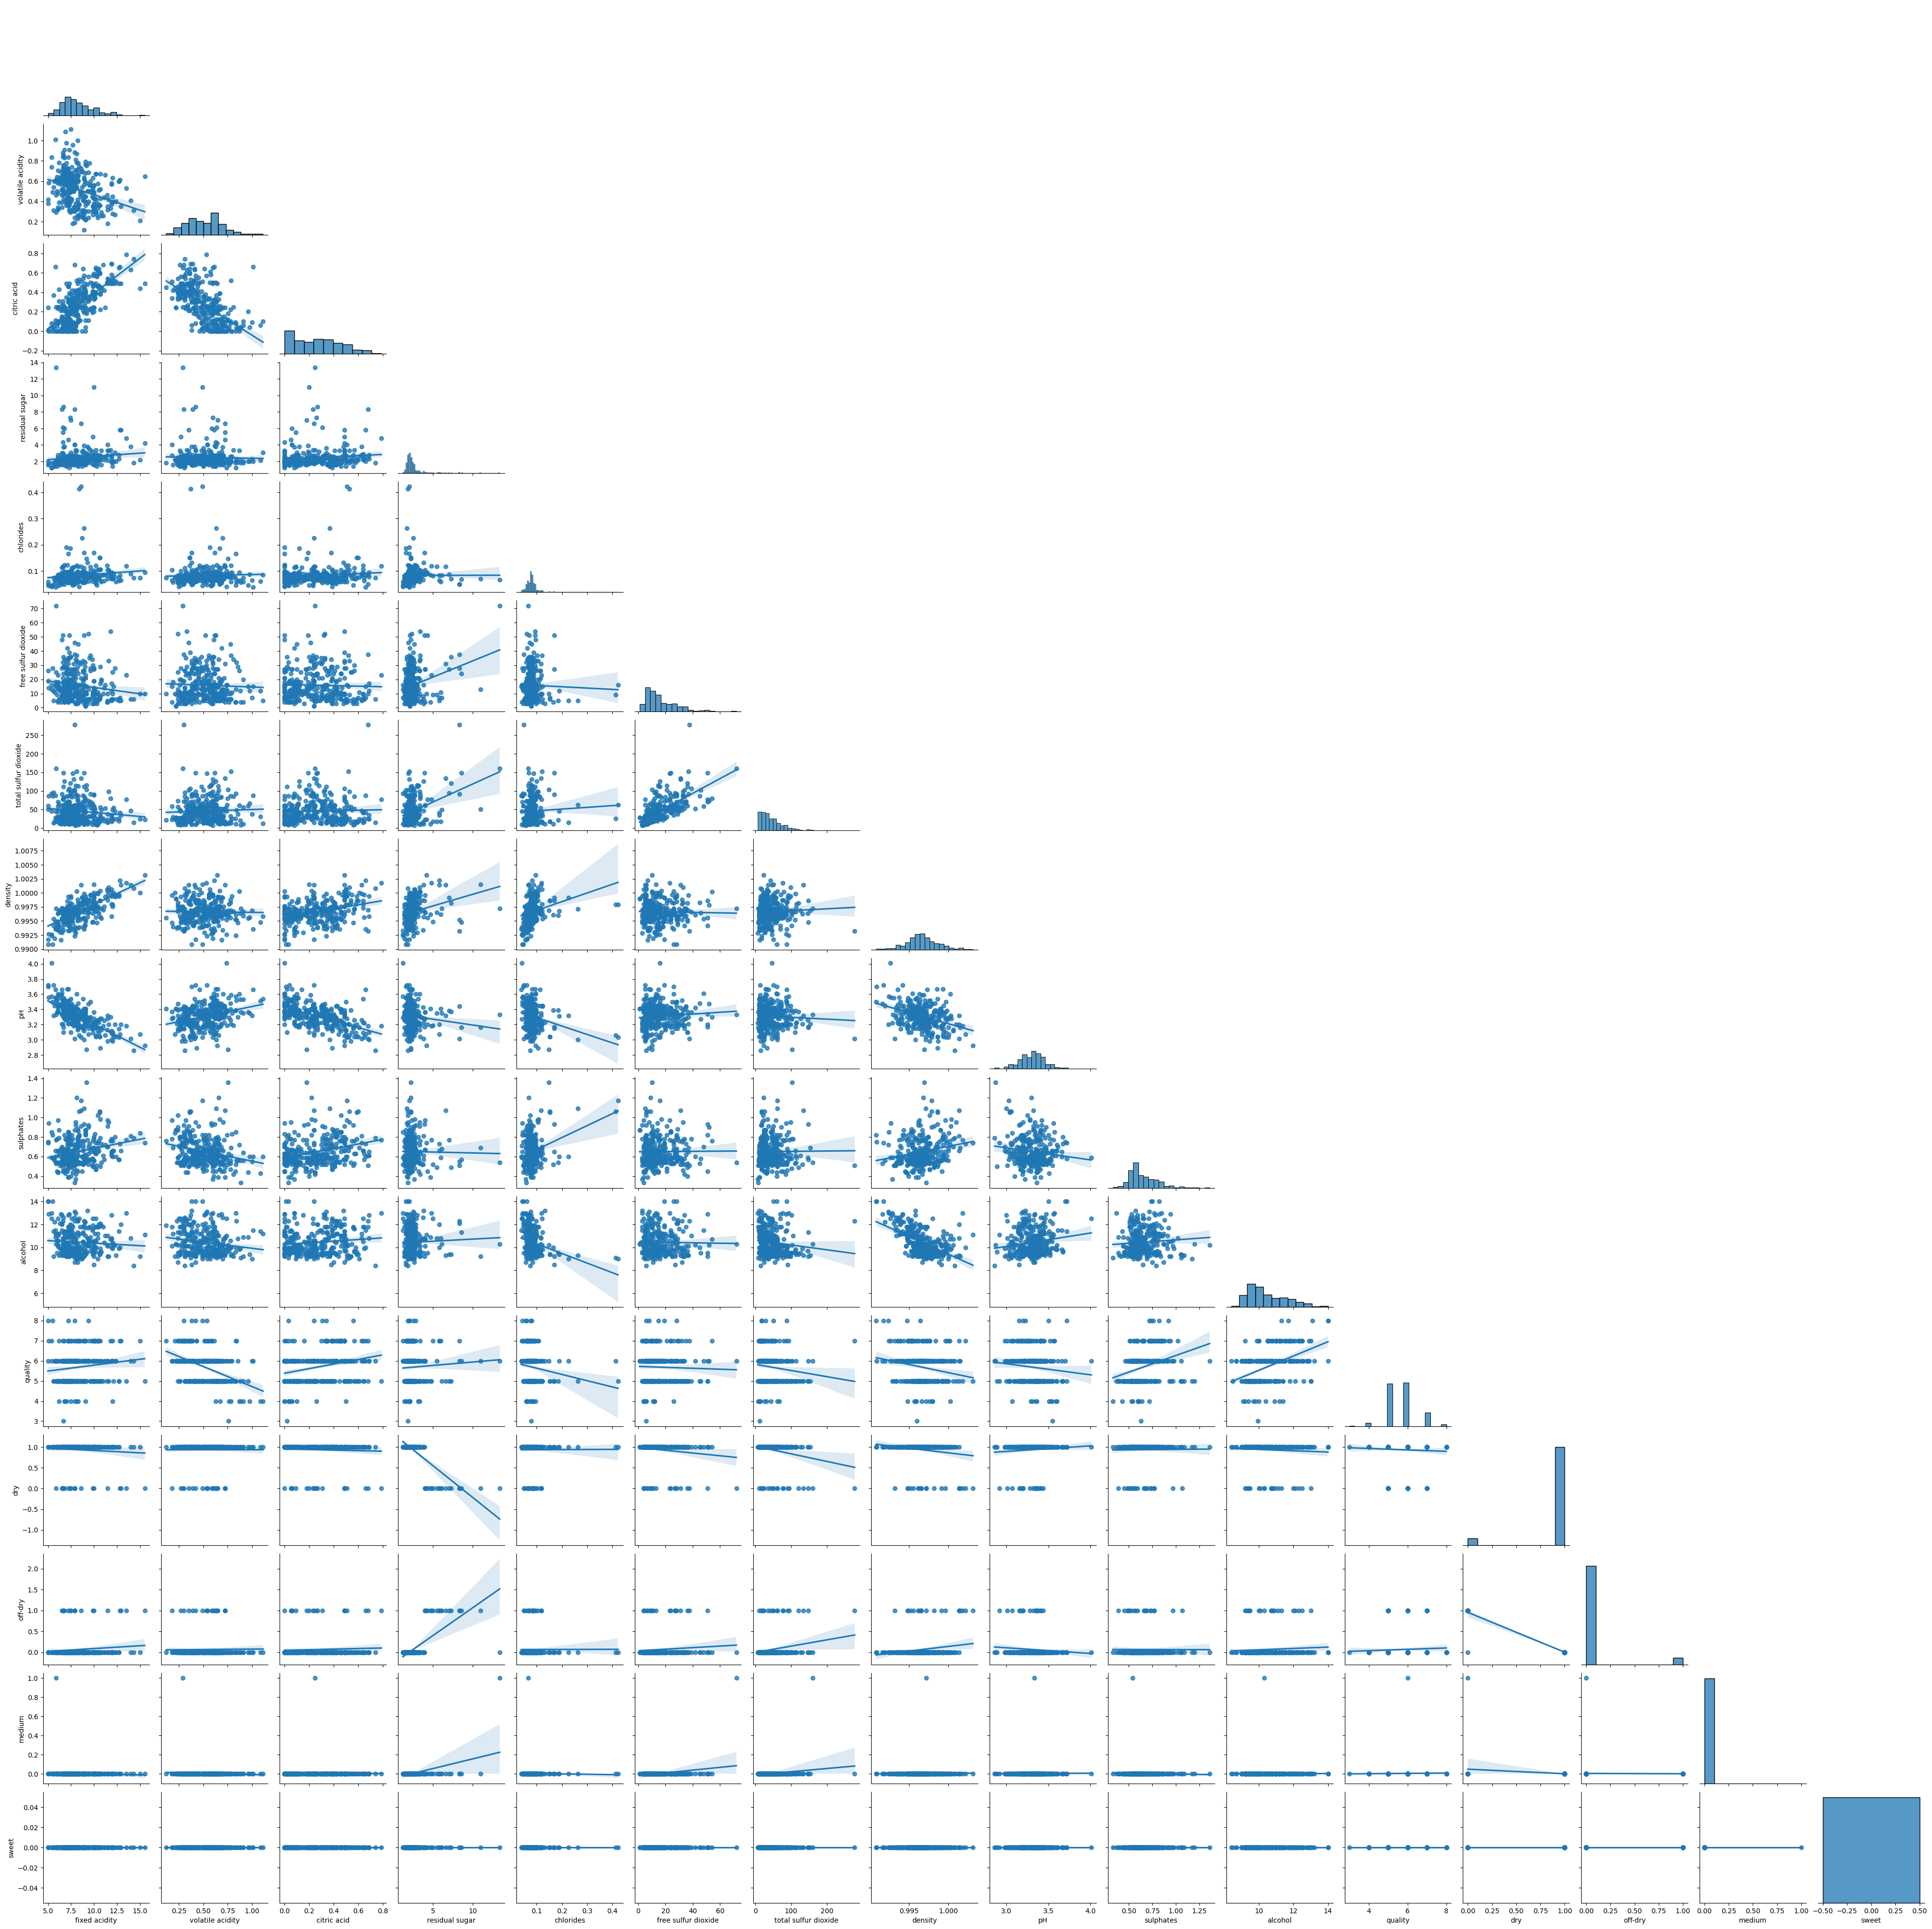

In [14]:
# подивимось детальніше на залежність фіч одна від одної
sns.pairplot(df_red.sample(frac=0.2, random_state=42), corner=True, kind='reg', diag_kind='hist')
# тут ми небачимо серйозних оутлеєрів по residual sugar,	chlorides, sulphates, total sulfur dioxide.
# можна побачити що для самих якісних вин chlorides, sulphates, total sulfur dioxide - мінімальні, або середні, теж саме ми можемо побачити на t sne репрезентації
# по-хорошему всеж таки отримати більше даних про вина якості 
# хоча тіж chlorides мають вищі значення для вин якості 3 та 4, тож скоріш за все ми би не побачили сильної зміни глобальної картини
# також дивимось на залежність нових фіч і quality - бачимо що тенденція сзміни дуже мала і лінія тренду лежить між найбільш поширеними класами
# проаналізувавши залежності зі схожими лініями тренду можемо зробити висновок, що фічі, які мають найменшу середню кореляцію більш вимогливі до рівномірного розподілу таргетів в датасеті
# але мають значно спрощувати навчання моделі

In [15]:
 # розділимо наш датафрейм на цільову змінну та ознаки
target = "quality"
df_target, df_fitches = df_red[target], df_red.drop(columns=[target])

In [16]:
# розіб'ємо df на тренувальну та валідаційну вибірку
# df_fitches_scalled = scaler.fit_transform(df_fitches)  # але перед цим одразу нормалізуємо дані. scaller вже створено вищє, тож повторне створеня не потрібно
X_train, X_val, y_train, y_val = train_test_split(df_fitches, df_target, test_size=0.15, random_state=42, stratify=df_target)

#stratify=y: цей параметр використовується для стратіфікованого розділення,
#тобто для того, щоб пропорція класів у цільовій змінній (y) залишалась однаковою як у тренувальному, так і у тестовому наборах.
#  Це важливо, якщо цільова змінна має дисбаланс класів, щоб зберегти репрезентативність даних у кожному наборі.



In [17]:
# перед тим як почати тренувати моделі проведемо кросвалідацію щоб переконатись, що наші вибірки збалансовані
from sklearn.model_selection import cross_val_score

reg_model = LinearRegression()
X_concated, y_concated = np.concat([X_train, X_val], axis=0), np.concat([y_train, y_val], axis=0)
# проводимо крос-валідацію по всьому датасету, це дасть кращє розуміння щодо його репрезентативності
cv_scores = cross_val_score(reg_model, X_concated, y_concated, cv=5)

print(cv_scores)

[0.35495392 0.27746837 0.33260914 0.32913721 0.42825831]


In [18]:
# бачимо певний дісбаланс у фолдах. Це підтверждує що у нас є певні проблеми з репрезентативнісю даних.
# імовірніше за все це пов'язано із великим дісбалансом класів. 
# якщо б ми не знали про дісбаланс класів, варто було б думати в сторону надмірної кореляції ознак з таргетом, але ми знаємо, що сильно корелюючі ознаки відсутні


In [19]:
# подивимось що нам дасть стратифікована крос-валідація (забезпечує рівномірний розподіл класів у фолдах))
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
cv_scores_skf = cross_val_score(reg_model, X_concated, y_concated, cv=skf)
print("skf", cv_scores_skf)
print("cv ", cv_scores)


skf [0.35020797 0.29562338 0.34297521 0.3263263  0.42670312]
cv  [0.35495392 0.27746837 0.33260914 0.32913721 0.42825831]


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.3              0.65         0.10             2.9      0.089   
1            7.2              0.56         0.26             2.0      0.083   
2            7.6              0.78         0.00             1.7      0.076   
3            9.0              0.48         0.32             2.8      0.084   
4            6.7              0.46         0.24             1.7      0.077   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 17.0                  40.0  0.99803  3.29       0.55   
1                 13.0                 100.0  0.99586  3.26       0.52   
2                 33.0                  45.0  0.99612  3.31       0.62   
3                 21.0                 122.0  0.99840  3.32       0.62   
4                 18.0                  34.0  0.99480  3.39       0.60   

   alcohol  dry  off-dry  medium  sweet  
0      9.5    1        0       0      0  
1 

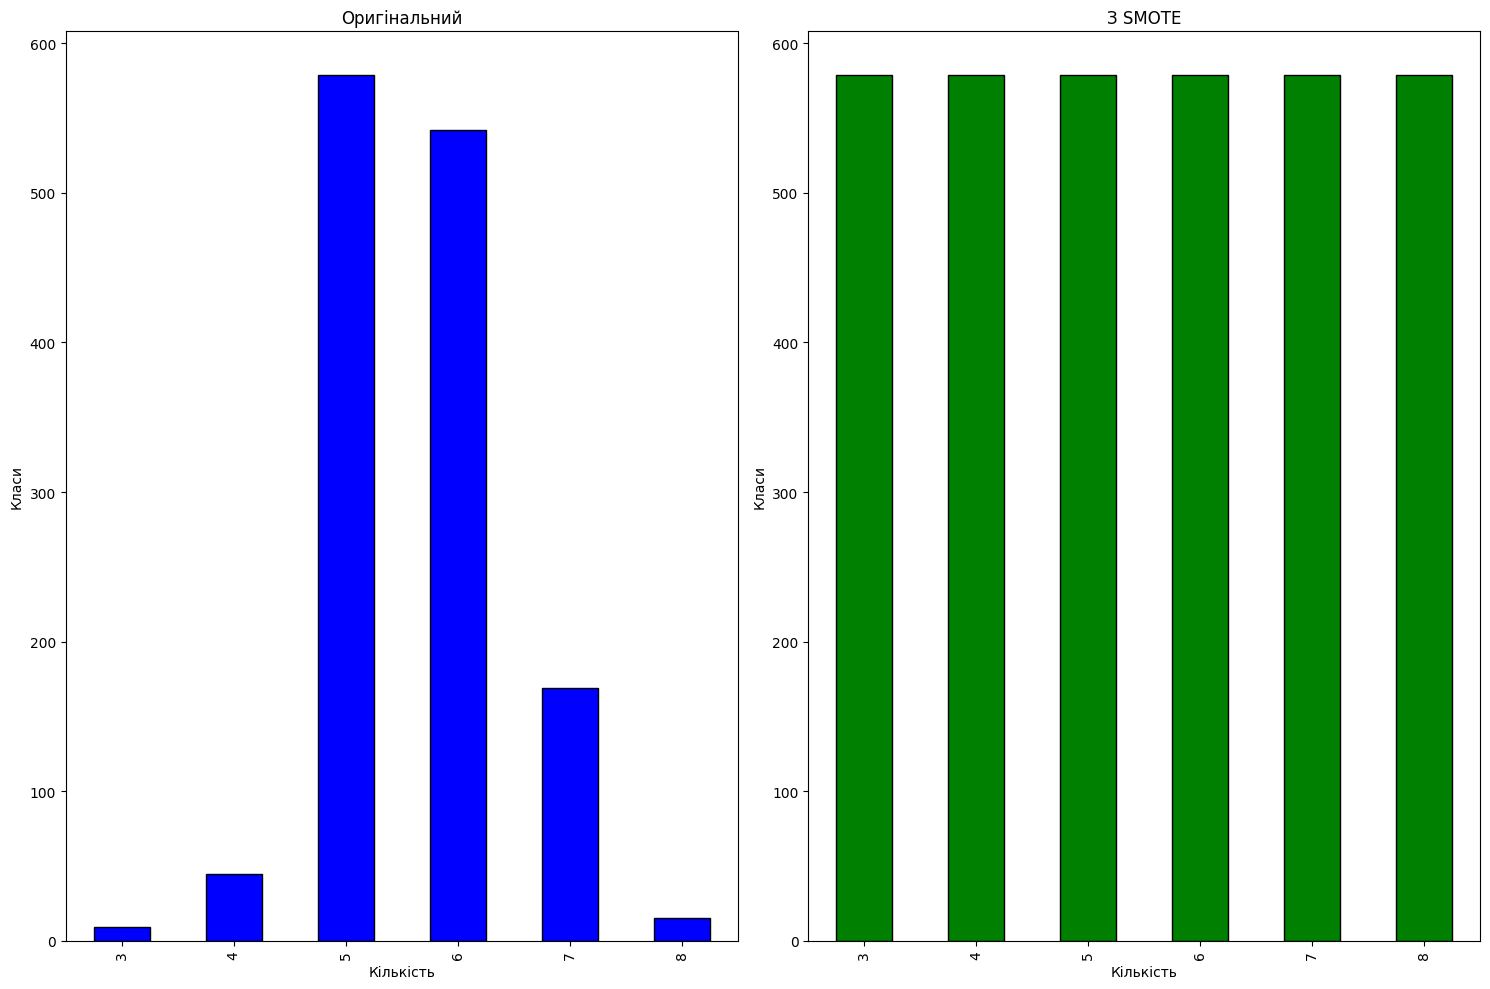

In [20]:
# бачимо, що стало трохи кращє, але вцілому рівномірний розподіл класів не дуже допоміг, але певна тенденція для покращєння є. Тож наші варіанти:
# створити нових фіч і спробувати із ними (як читання документації залишимо на самий кінець)
# видалити найбільш представлені класи - не можемо собі дозволити, так як мало даних
# створити синтетичні дані
from imblearn.over_sampling import SMOTE # pip3 install imblearn

gmo_maker = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = gmo_maker.fit_resample(X_train, y_train)

X_train_resampled_scalled = scaler.fit_transform(X_train_resampled)
print(X_train_resampled.head())
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

for i, (data, name) in enumerate(zip([y_train, y_train_resampled], ["Оригінальний", "З SMOTE"])):
    data.value_counts().sort_index().plot(kind="bar", ax=axes[i], color='b' if i == 0 else 'g', edgecolor='k')
    axes[i].set_xlabel("Кількість")
    axes[i].set_ylabel("Класи")
    axes[i].set_title(name)

plt.tight_layout()
plt.show()


In [21]:
# проводимо крос-валідацію по всьому датасету, це дасть кращє розуміння щодо його репрезентативності
cv_scores = cross_val_score(reg_model, X_train_resampled_scalled, y_train_resampled, cv=5)
print(cv_scores)

# бачимо, що стало щє гірше, тож недарма на нормальних продуктах пишуть "Без ГМО"

[ -0.5424579   -0.12891616  -7.74641909   0.6174083  -11.62044611]


[to drop] fixed acidity^2 --> 0.990416874467042
[to drop] fixed acidity citric acid --> 0.8261064937025548
[to drop] fixed acidity density --> 0.9999757030009264
[to drop] fixed acidity pH --> 0.9830250550612986
[to drop] fixed acidity alcohol --> 0.8974871781900162
[to drop] fixed acidity volatile acidity --> 0.8237207414585966
[to drop] volatile acidity^2 --> 0.9693880059890131
[to drop] volatile acidity density --> 0.9999839494931996
[to drop] volatile acidity pH --> 0.9902594680361051
[to drop] volatile acidity alcohol --> 0.9552749434789529
[to drop] volatile acidity citric acid --> 0.8460671409176228
[to drop] citric acid^2 --> 0.9469074420766826
[to drop] citric acid density --> 0.999994205697974
[to drop] citric acid pH --> 0.9972571924199155
[to drop] citric acid sulphates --> 0.9097294413175181
[to drop] citric acid alcohol --> 0.9843223605368455
[to drop] fixed acidity residual sugar --> 0.915460982784624
[to drop] volatile acidity residual sugar --> 0.8116471513772981
[to d

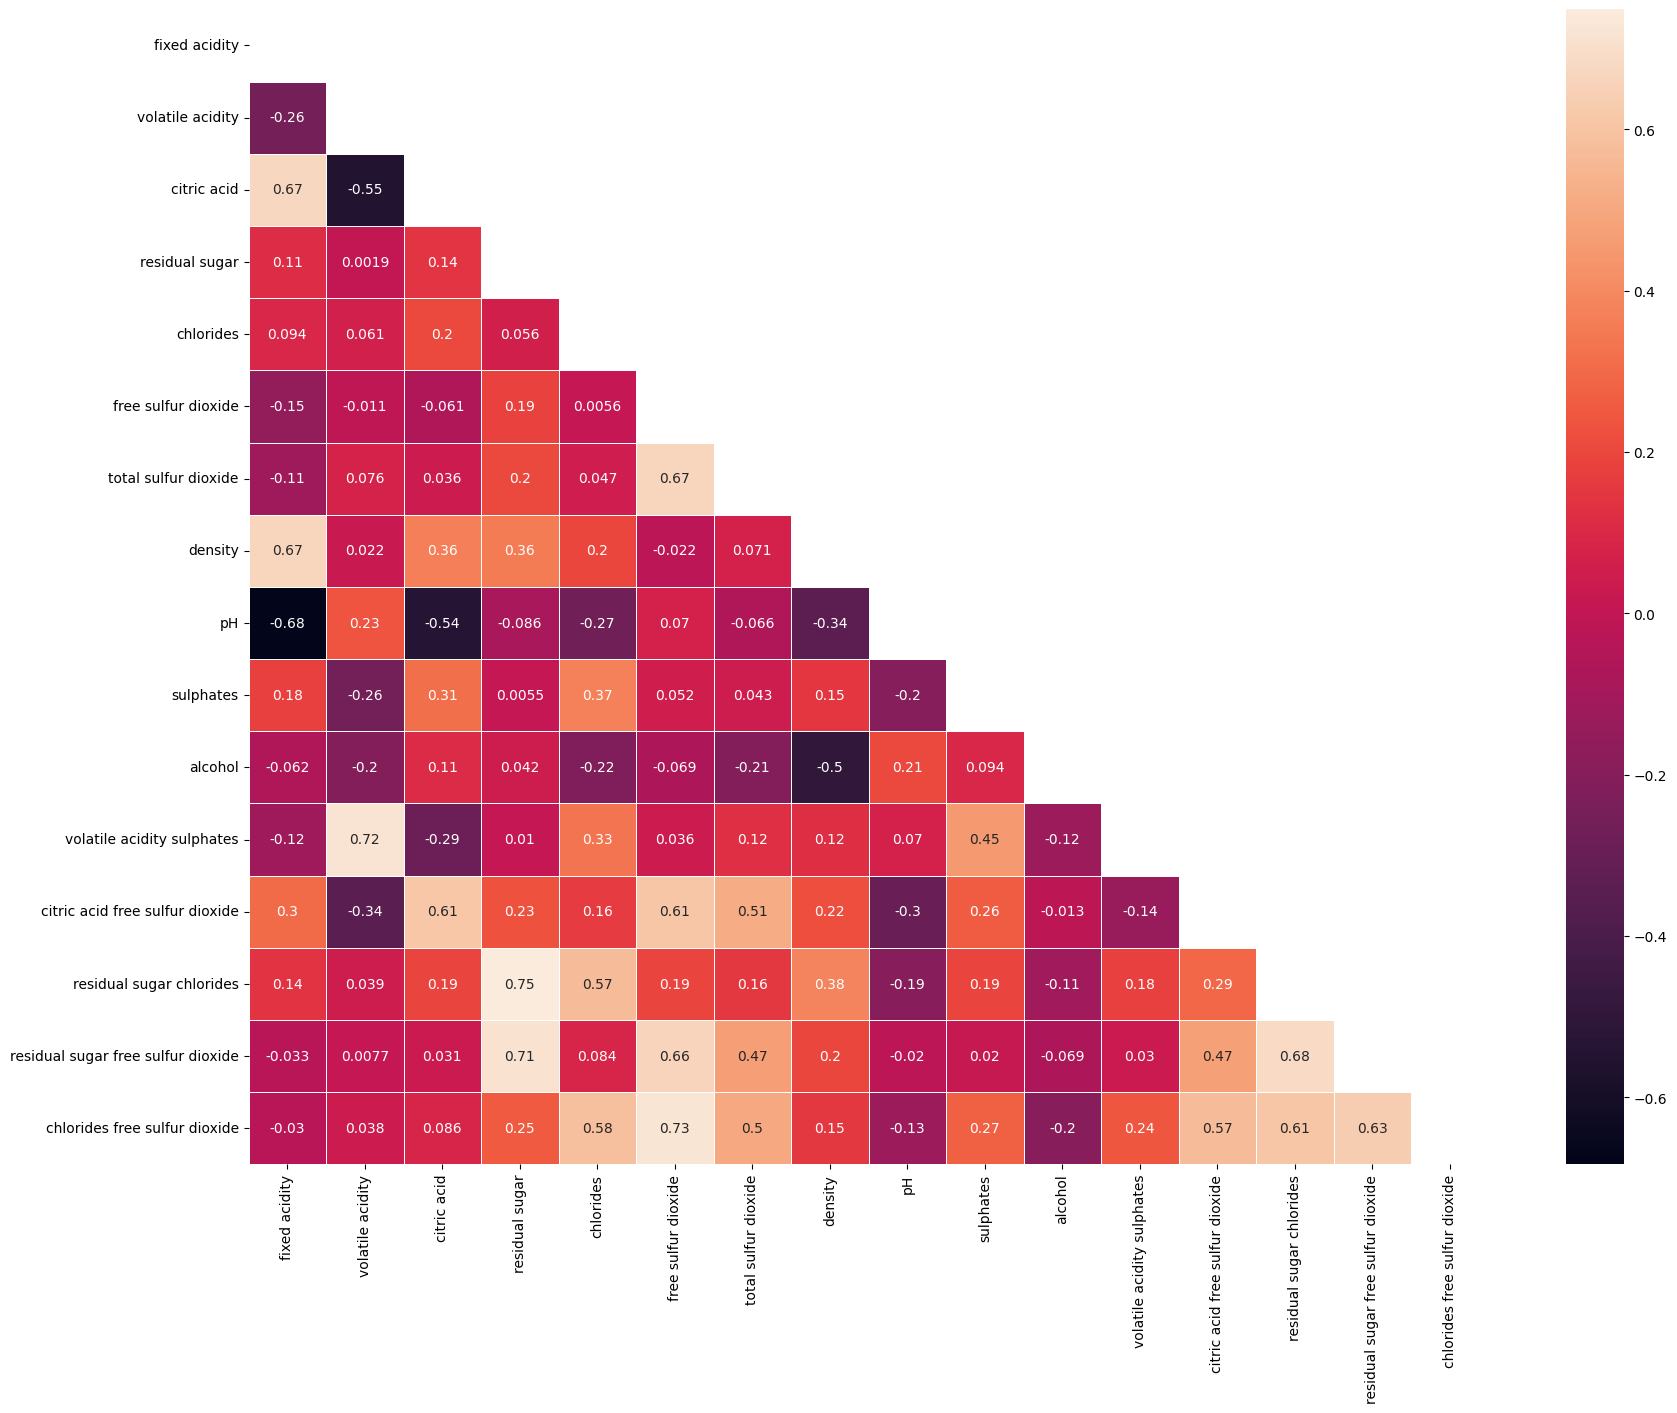

In [22]:
from sklearn.preprocessing import PolynomialFeatures
pd.set_option('display.max_columns', None)

df_fitches.drop(columns=["dry", "off-dry", "medium", "sweet"], inplace=True)



poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

X_train_poly = poly.fit_transform(df_fitches) # додаємо поліноміальні ознаки

# Отримання імен нових поліноміальних ознак
poly_feature_names = poly.get_feature_names_out(df_fitches.columns)

# Створення DataFrame з новими ознаками
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names)

# видалимо ознаки, з кореляцією більше 0.8 та оригінальні ознаки

# X_train_poly_df.drop(columns=df_fitches.columns, inplace=True)
fitches_corr_matrix = X_train_poly_df.corr()
to_drop = []
        
for i in range(len(fitches_corr_matrix.columns)):
    for j in range(i + 1, len(fitches_corr_matrix.columns)):
        if .8 <= fitches_corr_matrix.iloc[i, j] < 1:  # 
            colname = fitches_corr_matrix.columns[j]
            if colname not in to_drop:
                to_drop.append(colname)
                print(f"[to drop] {colname} --> {fitches_corr_matrix.iloc[i, j]}")
X_train_poly_df.drop(columns=to_drop, inplace=True)

# подивимось що залишилось
fitches_corr_matrix = X_train_poly_df.corr()
mask = np.triu(np.ones_like(fitches_corr_matrix, dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(fitches_corr_matrix, mask=mask, annot=True, linewidths=0.5) 

X_train_poly_df_scalled = scaler.fit_transform(X_train_poly_df)

In [23]:
X_train_poly_df_scalled = sm.add_constant(X_train_poly_df_scalled)
cv_scores = cross_val_score(reg_model, X_train_poly_df_scalled, y_concated, cv=5)
print(cv_scores)

# нам вдалось добитись того, що дані стали стабільно поганими, тож повернемось до того що мали

[-0.01116072 -0.05248257 -0.01285088 -0.02090704 -0.04067739]


In [24]:
# додамо логів
def get_scores(predicted, y, plot=True):
    r2 = r2_score(y_true=y, y_pred=predicted)
    mse = mean_squared_error(y_true=y, y_pred=predicted)
    accuracy = accuracy_score(y_true=y, y_pred=np.round(predicted))
    recall = recall_score(y_true=y, y_pred=np.round(predicted), average="micro") # так як наш датасет незбалансований
    f1 = f1_score(y_true=y, y_pred=np.round(predicted), average="micro")
    if plot:
        plot_results(y=y, predicted=predicted)
    return f"r2: {r2}\nmse: {mse}\naccuracy: {accuracy}\nrecall: {recall}\nf1: {f1}"

def plot_results(y, predicted):
    
    losses = y - predicted
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Scatter Plot залишків
    axs[0, 0].scatter(predicted, losses, alpha=0.5)
    axs[0, 0].axhline(y=0, color='r', linestyle='--')
    axs[0, 0].set_xlabel('Передбачені значення')
    axs[0, 0].set_ylabel('Залишки')
    axs[0, 0].set_title('Scatter Plot залишків')

    # 2. Гістограма залишків
    sns.histplot(losses, kde=True, ax=axs[0, 1], bins=20, color='b', edgecolor='k')
    axs[0, 1].set_xlabel('Залишки')
    axs[0, 1].set_ylabel('Частота')
    axs[0, 1].set_title('Гістограма залишків')

    # 3. Передбачені значення vs Істинні значення
    axs[1, 0].scatter(y, predicted, alpha=0.5, color='g')
    axs[1, 0].plot([y.min(), y.max()], [y.min(), y.max()], color='r', linestyle='--')
    axs[1, 0].set_xlabel('Істинні значення')
    axs[1, 0].set_ylabel('Передбачені значення')
    axs[1, 0].set_title('Передбачені значення vs Істинні значення')

    # 4. Q-Q Plot залишків
    sm.qqplot(losses, line='s', ax=axs[1, 1])
    axs[1, 1].set_title('Q-Q графік залишків')

    # Налаштування та показ графіка
    plt.tight_layout()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     56.79
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          7.07e-118
Time:                        13:21:54   Log-Likelihood:                -1341.3
No. Observations:                1359   AIC:                             2711.
Df Residuals:                    1345   BIC:                             2784.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.6712 

/home/dobriykot/HilelML/venv-ml/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


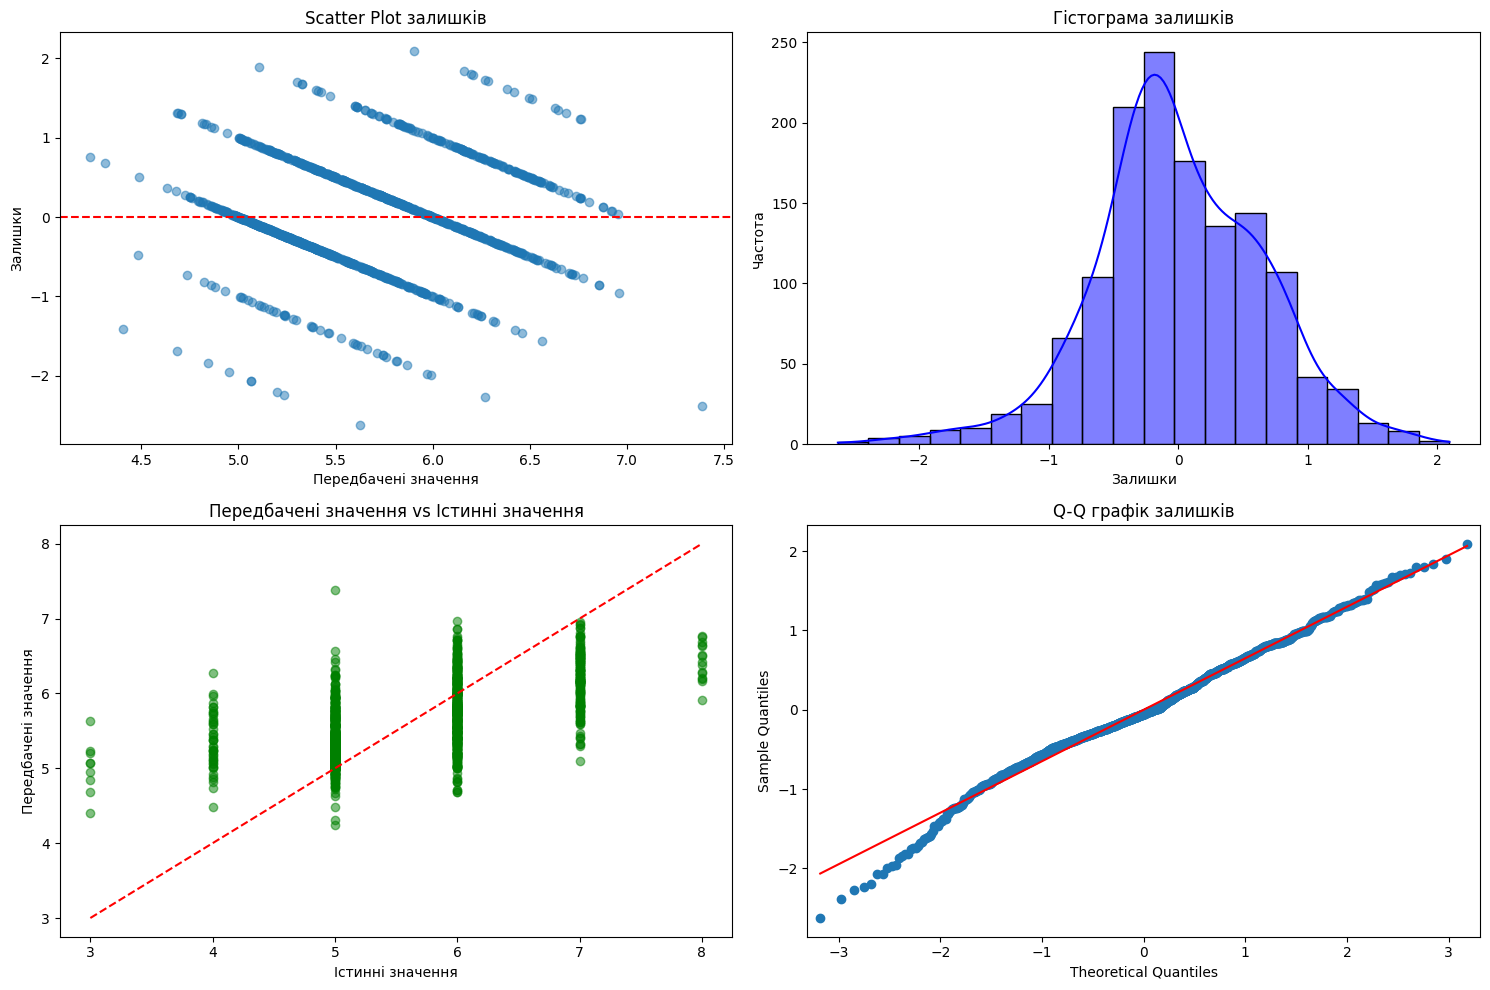

r2: 0.3543654998875849
mse: 0.42151148131609234
accuracy: 0.5916114790286976
recall: 0.5916114790286976
f1: 0.5916114790286976


In [25]:
X_train = sm.add_constant(X_train)  # Додаємо константу
X_val = sm.add_constant(X_val)  # без has_constant константа не додавалась і масиви не співпадали за розмірами

model = sm.OLS(y_train, X_train)
res = model.fit()
print(res.summary())

# Подивимось на похибки на тренувальній вибірці
y_pred_train = res.predict(X_train)
print(get_scores(y_pred_train, y_train))


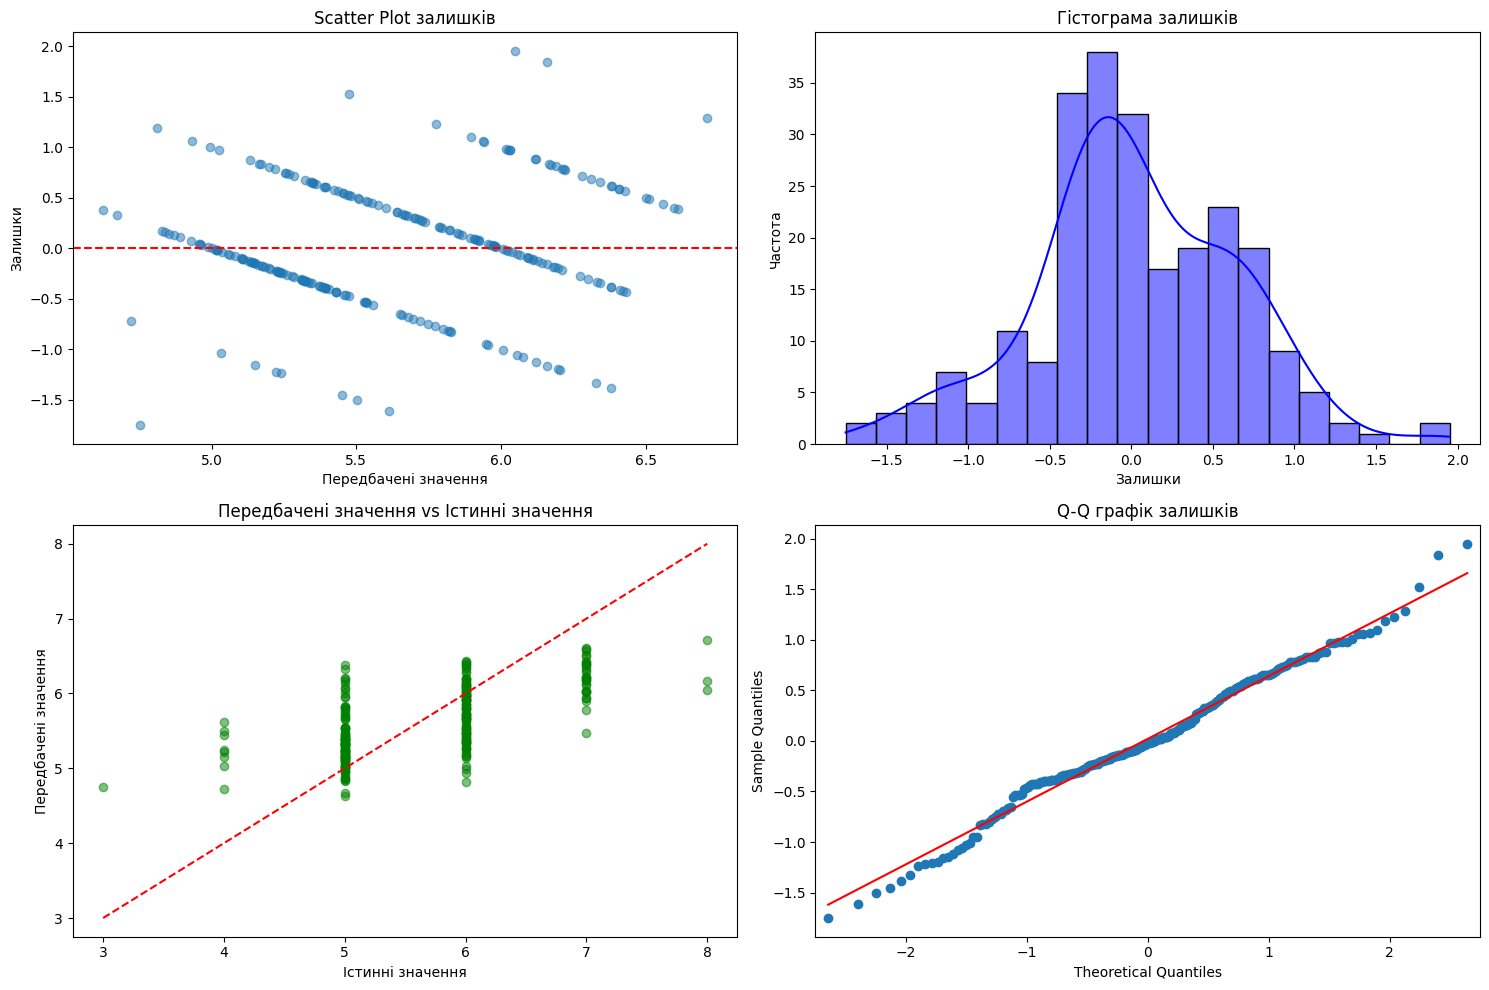

r2: 0.40092725452296885
mse: 0.386641133908136
accuracy: 0.6125
recall: 0.6125
f1: 0.6125


In [26]:
y_val_pred = res.predict(X_val)
print(get_scores(y=y_val, predicted=y_val_pred))


In [27]:
# через 6-8 годин додавання та видалення нових ознак я згадав, що ти казав, що все що між 0.25 - 0.4 - це нормально.
# Але дивлячись на графік, відчуття нормальності пропадає... Можливо я його невірно інтерпритую, але є відчуття, що графік мав би бути менш упорядоченим

-0.020376355735578434


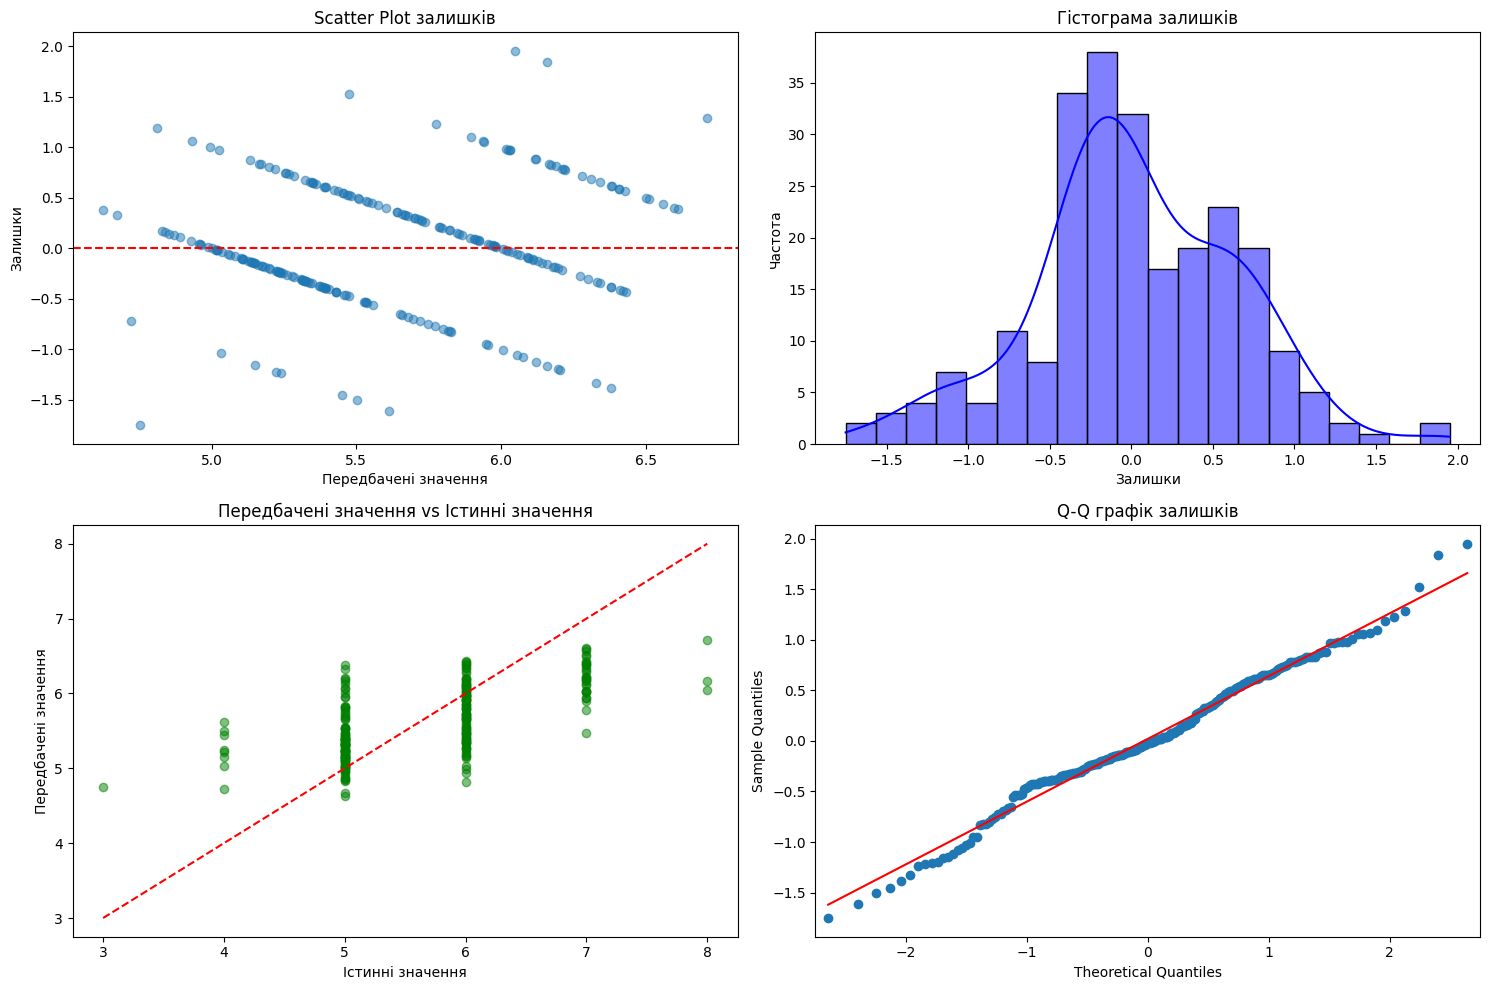

r2: 0.40092725452297306
mse: 0.3866411339081332
accuracy: 0.6125
recall: 0.6125
f1: 0.6125


In [28]:
# спробуємо sklearn
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
reg_model.score(X_train, y_train)  # >> 0.3543654998875848 - схожий результат з OLS

res = reg_model.predict(X_val)

loss = res - y_val  
print(loss.mean())  # >> -0.02037635573557669 значення близьке до нуля це значить що модель досить добре працює,
                    #від'ємне значення каже про те, що модель глобаль трохи переоцінює вина. Хоча, всі ми трохи переоцінюємо вина)

#так як модель на виходах не дає в якості передбачення чілих чисел - зробимо щось ша кшталт relu

val_pred = reg_model.predict(X_val)
print(get_scores(y=y_val, predicted=val_pred))



In [29]:
# для обох моделей бачимо однакові графіки та показники. Що і не дивно, бо обидві використовують матричний метод і знайти якусь відмінність вкрай важко.
# на валідаційній виборці моделі показали трохи кращі результати
# accuracy, recal та f1 мають однакові значення, оскільки дані передбачені були округлені для інтерпретування у класифікаційному сенсі. 
# на графіках явно відстежуються патерни розташування точок, що може свідчити про те що модель не врахувала деякі важливі взаємозв'язки,
# ми точно можемо виключити із причин високу кореляцію між фічами так як ми їх перевіряли. Імовірно існують нелінійні зв'язки між даними, яка модель не може врахувати 

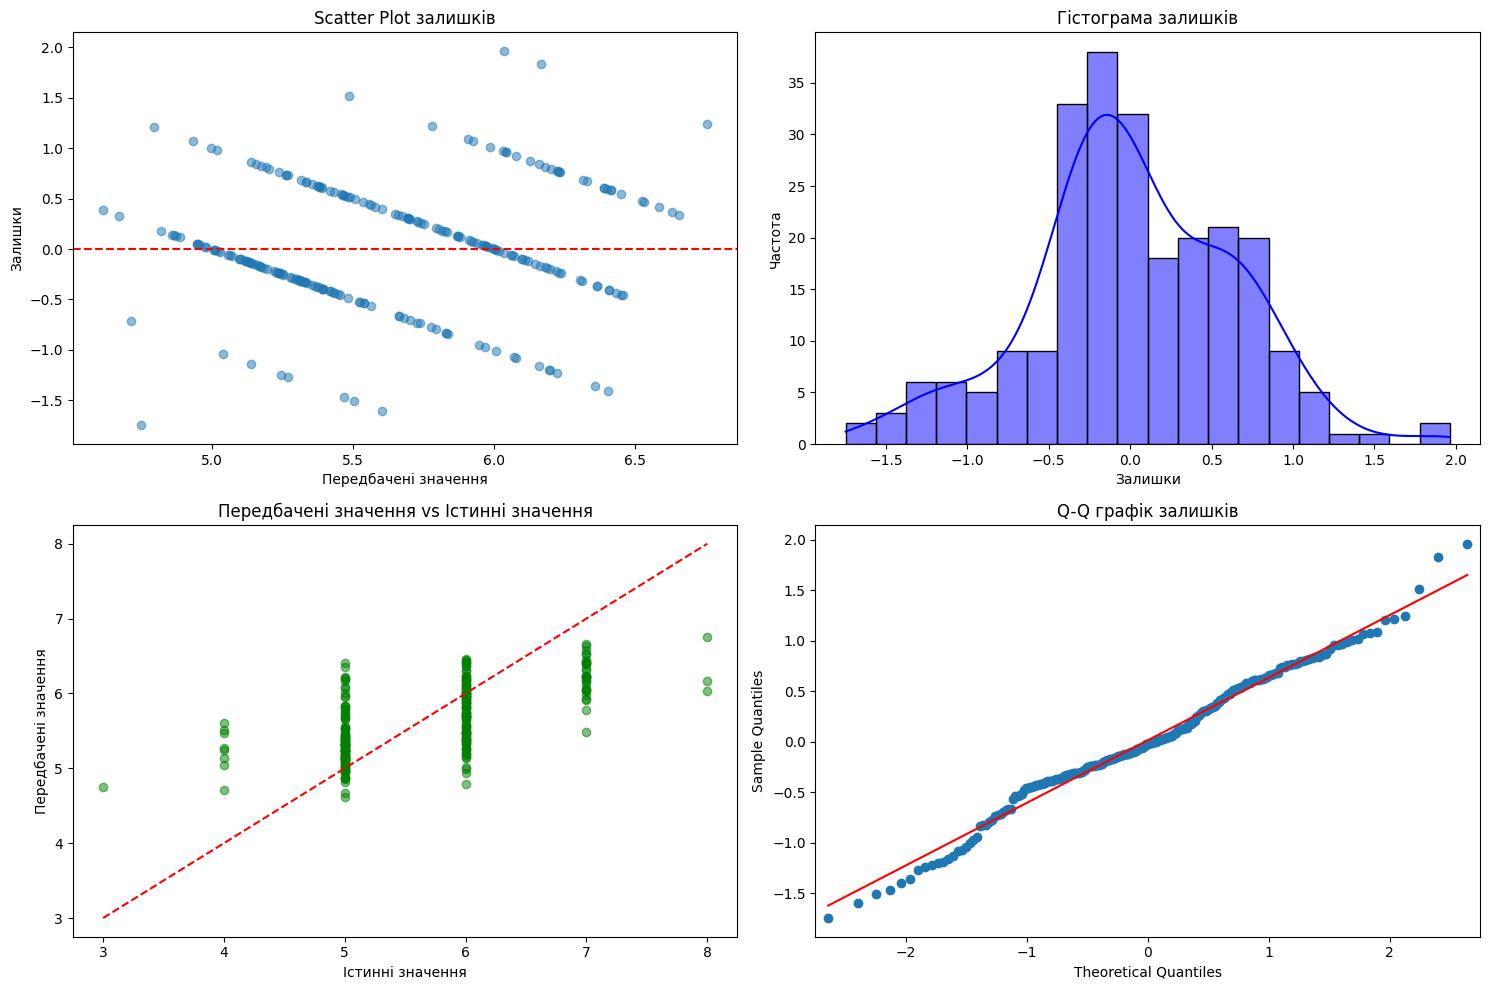

r2: 0.4026434142454728
mse: 0.38553352561500953
accuracy: 0.6083333333333333
recall: 0.6083333333333333
f1: 0.6083333333333333


In [30]:
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
reg.fit(X_train, y_train)  # подаємо не нормалізовані дані, так як ми передали об'єкт StandardScaller в об''єк моделі

y_pred = reg.predict(X_val)


print(get_scores(predicted=y_pred, y=y_val))

In [31]:
# модель лінійної регресії має дуже схожі метрики, майже ідентичні
# доречі ми не нормалізували в попередніх моделях таргети, тут нормалізація також автоматично відбулась і до таргетів, що в задачах лінійної регресії є бажаним
# але бачимо що це не вплинуло глобально на отриманий результат

In [32]:
X_train_scld, X_val_scld = map(lambda x: scaler.fit_transform(x), [X_train, X_val])
# нормалізую дані, щоб не використовувати pipeline, бо доведеться писати багато букв в словнику параметрів

In [33]:
X_train

const  fixed acidity  volatile acidity  citric acid  residual sugar  \
750     1.0            8.3             0.650         0.10            2.90   
1375    1.0            7.2             0.560         0.26            2.00   
1046    1.0            7.6             0.780         0.00            1.70   
693     1.0            9.0             0.480         0.32            2.80   
1327    1.0            6.7             0.460         0.24            1.70   
...     ...            ...               ...          ...             ...   
240     1.0            8.9             0.635         0.37            1.70   
247     1.0            8.2             0.600         0.17            2.30   
682     1.0            8.5             0.460         0.31            2.25   
828     1.0            7.8             0.570         0.09            2.30   
612     1.0            7.5             0.640         0.00            2.40   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
750       0.089                 17.0                  40.0  0.99803  3.29   
1375      0.083                 13.0                 100.0  0.99586  3.26   
1046      0.076                 33.0                  45.0  0.99612  3.31   
693       0.084                 21.0                 122.0  0.99840  3.32   
1327      0.077                 18.0                  34.0  0.99480  3.39   
...         ...                  ...                   ...      ...   ...   
240       0.263                  5.0                  62.0  0.99710  3.00   
247       0.072                 11.0                  73.0  0.99630  3.20   
682       0.078                 32.0                  58.0  0.99800  3.33   
828       0.065                 34.0                  45.0  0.99417  3.46   
612       0.077                 18.0                  29.0  0.99650  3.32   

      sulphates  alcohol  dry  off-dry  medium  sweet  
750        0.55      9.5    1        0       0      0  
1375       0.52      9.9    1        0       0      0  
1046       0.62     10.7    1        0       0      0  
693        0.62      9.4    1        0       0      0  
1327       0.60     10.6    1        0       0      0  
...         ...      ...  ...      ...     ...    ...  
240        1.09      9.3    1        0       0      0  
247        0.45      9.3    1        0       0      0  
682        0.54      9.8    1        0       0      0  
828        0.74     12.7    1        0       0      0  
612        0.60     10.0    1        0       0      0  

[1359 rows x 16 columns]

Fitting 4 folds for each of 15360 candidates, totalling 61440 fits


/home/dobriykot/HilelML/venv-ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/dobriykot/HilelML/venv-ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/dobriykot/HilelML/venv-ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/dobriykot/HilelML/venv-ml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
 

Найкращі параметри:  {'alpha': np.float64(0.0001), 'average': False, 'eta0': np.float64(0.1), 'fit_intercept': True, 'l1_ratio': np.float64(0.43333333333333335), 'learning_rate': 'adaptive', 'max_iter': 2000, 'penalty': 'elasticnet', 'tol': 0.001}
Найкращий результат R^2:  0.33655183462273064
coef:  [ 0.         -0.01868204 -0.18004131 -0.01556342  0.07178505 -0.09216733
  0.0594727  -0.12704523  0.00706606 -0.09611703  0.13973577  0.31758835
  0.04949828 -0.02164562 -0.03697791  0.        ]


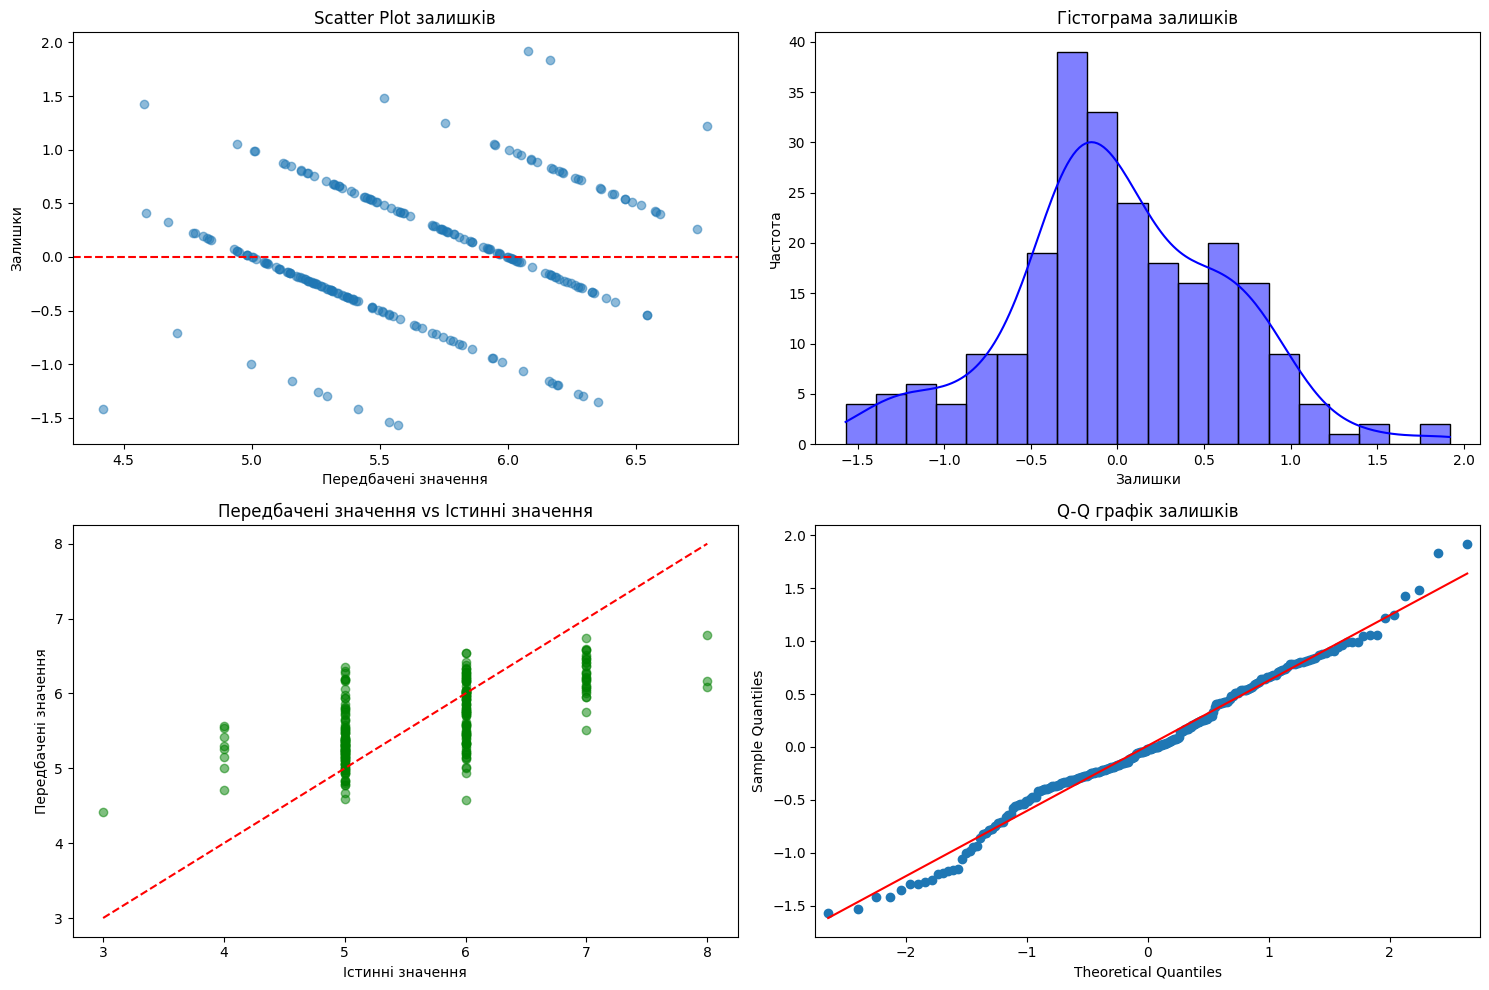

r2: 0.41135974275568776
mse: 0.37990801324752266
accuracy: 0.6
recall: 0.6
f1: 0.6


In [34]:
# спробуємо погратись з параметрами
from sklearn.model_selection import GridSearchCV

model = SGDRegressor(random_state=42, verbose=0, early_stopping = False, loss="squared_error", shuffle=True)

# Словник параметрів для перебору
param_grid = {
    "max_iter": [2000, 4000],
    "penalty": ["l2", "l1", "elasticnet"],
    'alpha': np.linspace(0.0001, 0.01, 4), # Константа, що множить регуляризаційний член. Вища значення – сильніше регуляризація.
    "l1_ratio": np.linspace(0.15, 1, 4),  # 0 -> чистий L2  регуляризатор; 1, чистий L1 ;  0 < l1_ratio < 1  комбінацію L1 і L2 регуляризацій.
    "fit_intercept": [True, False],
    "tol": [1e-2, 1e-3], # early stopping
    "learning_rate": ["invscaling", "constant", "optimal", "adaptive"], 
    "eta0": np.linspace(0.0001, 0.1, 5), # початкова швидкість навчання
    "average": [True, False]
}


# Використовуємо GridSearchCV для підбору параметрів
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, n_jobs=-1, scoring='r2', verbose=1)

# Навчання за допомогою GridSearchCV на тренувальних даних
grid_search.fit(X_train_scld, y_train)

# Найкращі параметри та оцінка моделі з використанням крос-валідації                                                                                                                                                                                                                                                                                                                                      ЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙЙ
print("Найкращі параметри: ", grid_search.best_params_)
print("Найкращий результат R^2: ", grid_search.best_score_)

# Використовуємо найкращу модель для передбачення
best_model = grid_search.best_estimator_   
print("coef: ", best_model.coef_)
# print("fetures: ", best_model.feature_names_in_) # працює, якщо подаємо датафрейм
y_pred = best_model.predict(X_val_scld)
print(get_scores(predicted=y_pred, y=y_val))

In [35]:
# бачимо що впринципі досягли таких самих результатів як і без перебору гіперпараметрів, хоча вони відрізняються від стандартних
# ваги мають низькі значення, тож модель явно не перенавчається
# останній коефіцієнт дорівнює нулю - тож він не є якимось важливим. Це фіча - sweet і вона майже не представлена в датасеті.
# по-хорошему варто було б спробувати розбити датасет на датасети по сухості вин і дослідити їх окремо
# також бачимо що для деяких комбінацій у нас не вистачило ітерацій щоб модель зійшлась

In [36]:
df_red_dry = df_red[df_red["dry"] == 1].copy()
df_red_dry.drop(columns=["dry", "off-dry", "medium", "sweet"], inplace=True)
df_red_dry

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1463 rows x 12 columns]

In [37]:

df_dry_fetures, df_dry_target = df_red_dry.drop(columns=["quality"]), df_red_dry["quality"]
df_dry_f_scalled = sm.add_constant(scaler.fit_transform(df_dry_fetures))
X_dry_train, X_dry_val, y_dry_train, y_dry_val = train_test_split(df_dry_f_scalled, df_dry_target, test_size=0.15, random_state=42, stratify=df_dry_target)



score_train 0.38005009080482355


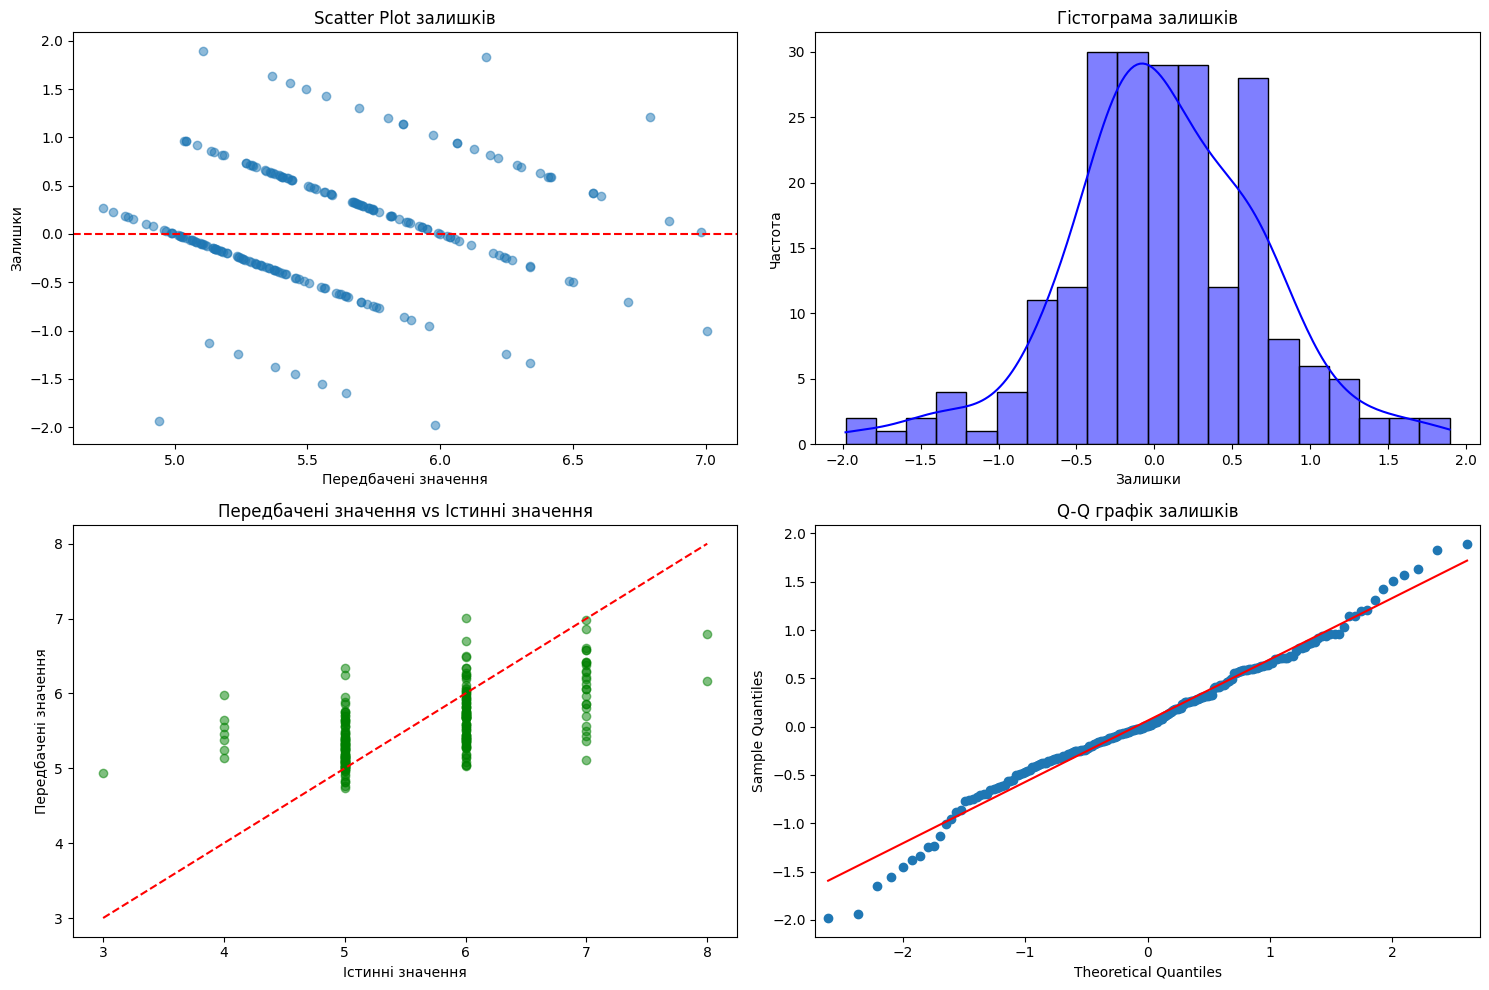

r2: 0.3380678750924426
mse: 0.4067189971616911
accuracy: 0.6136363636363636
recall: 0.6136363636363636
f1: 0.6136363636363636


In [38]:
dry_model = SGDRegressor(random_state=42)
res = dry_model.fit(X_dry_train, y_dry_train)
print("score_train", res.score(X_dry_train, y_dry_train))

predicted = dry_model.predict(X_dry_val)

print(get_scores(predicted=predicted, y=y_dry_val))

In [39]:
# Не зміг втриматись і всеж зробив модель тільки по сухим винам, але бачимо, що проблему це не вирішило тож розподілдатасету на піддатасети по типам солодкості вин - не є достатнім для вирішення проблеми.
# потрібно або глибше копати в сторону поліноміальних ознак, або застосовувати більш складні моделі, або використовувати нейронну мережу